In [253]:
import numpy as np
import scipy.signal
from scipy.io import wavfile
import scipy.io.wavfile
import librosa
import matplotlib.pyplot as plt
import os
from pandas import DataFrame
import time
from scipy.signal.windows import hamming
from sklearn.cluster import KMeans

In [254]:
# Lấy list wav files từ 1 folder
def get_wav_files(folder_path):
    wav_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))
    return wav_files

base_audio_train_folder = "NguyenAmHuanLuyen-16k"
audio_train_folders = [os.path.join(base_audio_train_folder, folder) for folder in os.listdir(base_audio_train_folder)]
audio_train_file_paths = []
for folder in audio_train_folders:
    folder_name = os.path.basename(folder)
    item = {
        'folder_name': folder_name,
        'audio_files': get_wav_files(folder)
    }
    audio_train_file_paths.append(item)

base_audio_test_folder = "NguyenAmKiemThu-16k"
audio_test_folders = [os.path.join(base_audio_test_folder, folder) for folder in os.listdir(base_audio_test_folder)]
audio_test_file_paths = []
for folder in audio_test_folders:
    folder_name = os.path.basename(folder)
    item = {
        'folder_name': folder_name,
        'audio_files': get_wav_files(folder)
    }
    audio_test_file_paths.append(item)


In [255]:
def find_vowel_files(audio_file_paths, vowel_file):
    vowel_files_in_paths = []
    for item in audio_file_paths:
        # Tìm các file trong list tương ứng của từng folder
        matching_files = [f for f in item['audio_files'] if os.path.basename(f) in vowel_file]
        if matching_files:
            vowel_files_in_paths.extend(matching_files)
    return vowel_files_in_paths


In [256]:
def format_accuracy_matrix(matrix):
    formatted_matrix = matrix.copy()
    for i in range(1, matrix.shape[0]):
        for j in range(1, matrix.shape[1]):
            # Chỉ format các ô không phải tiêu đề (giả định đây là số hoặc None)
            if matrix[i, j] is not None:
                formatted_matrix[i, j] = f"{matrix[i, j]:.1f}"
    return formatted_matrix

In [257]:
def show_accuracy_matrix(accuracy_percent_synthesis, title):
    formatted = format_accuracy_matrix(accuracy_percent_synthesis)
    fig, ax = plt.subplots(figsize=(8, 3))  # Modify the size as needed
    ax.set_title(title, color='blue', loc='center',fontweight='bold')
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=formatted, loc='center', cellLoc='center', edges='closed')
    table.auto_set_column_width(col=list(range(len(formatted[0]))))  
    table.auto_set_font_size(False)  
    table.set_fontsize(11)  
    fig.tight_layout()
    plt.show()


In [258]:
def show_statictics_table(statictics_table, title):
    # Vẽ bảng thống kê
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.axis('off')
    ax.axis('tight')
    ax.table(cellText=statictics_table, loc='center')
    fig.tight_layout()
    plt.show()

In [259]:
def show_feature_mfcc_vectors(feature_vectors, K, title1):
    N_MFCC = 13
    vowel_files = ["a.wav", "e.wav", "i.wav", "o.wav", "u.wav"] 
    n = np.arange(N_MFCC)
    plt.figure(figsize=(20,10))
    plt.title(title1)
    plt.plot(n, feature_vectors[0, :], 'b', label=vowel_files[0])
    plt.plot(n, feature_vectors[K, :], 'y', label=vowel_files[1])
    plt.plot(n, feature_vectors[2 * K, :], 'darkcyan', label=vowel_files[2])
    plt.plot(n, feature_vectors[3 * K, :], 'orange', label=vowel_files[3])
    plt.plot(n, feature_vectors[4 * K, :], 'r', label=vowel_files[4])
    plt.legend()
    plt.xlabel('Chỉ số')
    plt.ylabel('Hệ số MFCC')
    plt.show()
    plt.figure()

In [260]:
def show_confusion_matrix(confusion_matrix, title, time_processing_vowels):
    for row in confusion_matrix[1:]:
        if type(row[-1]) == float:  
            row[-1] = "{:.1f}".format(row[-1])
        else:
            row[-1] = ""
    df_cm = DataFrame(
        [row[1:] for row in confusion_matrix[1:]], 
        columns=confusion_matrix[0][1:],  
        index=[row[0] for row in confusion_matrix[1:]]  
    )

    avg_time_vowels = [round(item['avg_time'],4) for item in time_processing_vowels]
    avg_time_vowels.append("")
    df_cm['Time-Avg'] = avg_time_vowels
    fig, ax = plt.subplots(figsize=(14, 5))  
    ax.set_title(title, color='blue', loc='center', fontweight='bold')
    ax.axis('off')  
    tab = ax.table(cellText=df_cm.values, cellLoc='center', loc='center', rowLabels=df_cm.index, colLabels=df_cm.columns)
    tab.auto_set_font_size(False)
    tab.set_fontsize(14)
    tab.scale(1, 1.4)
    max_index = df_cm.iloc[:-1, -2].astype(float).idxmax()  # Tìm percent cao nhất
    min_index = df_cm.iloc[:-1, -2].astype(float).idxmin()  # Tìm percent thấp nhất


    for key, cell in tab.get_celld().items():
        if key[0] == 0:
            cell.set_text_props(color='black', fontweight='bold')
            cell.set_facecolor('lightgrey')
            
    for (i, row) in enumerate(df_cm.iterrows(), start=1):
        if row[0] == max_index :  # Highlight dòng có percent cao nhất
            for j in range(len(df_cm.columns)):
                tab[(i, j-1)].set_facecolor('lightgreen')
        if row[0] == min_index:   # Highlight dòng có percent thấp nhất
            for j in range(len(df_cm.columns)):
                tab[(i, j-1)].set_facecolor('salmon')
    
    plt.show()


In [261]:
def show_speech_stable(data, T, speech_area, sample_shift_frame, startTime, endTime):
    plt.figure()
    plt.plot(np.arange(0, len(data) * T, T), data) # tín hiệu sau khi chuẩn hóa
    plt.title("Speech and Stable Area of the Signal ")
    # Vẽ vùng tiếng nói
    plt.axvline(x=(speech_area[0]) * sample_shift_frame * T, color='r', linestyle='--', label="Start of Speech")
    plt.axvline(x=(speech_area[-1]) * sample_shift_frame * T, color='r', linestyle='--', label="End of Speech")
    # Vẽ vùng ổn định
    plt.axvline(x=(startTime) * sample_shift_frame * T, color='b', linestyle='--', label="Start of Stable Speech")
    plt.axvline(x=(endTime) * sample_shift_frame * T, color='b', linestyle='--', label="End of Stable Speech")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show() 

In [262]:
# Khoảng cách Euclidean giữa 2 vector
def euclideanDistance(v1, v2):
    return np.linalg.norm(v1 - v2)

In [263]:
def accuracy_percent_recognition(confusion_matrix, accuracy_percent_synthesis, idx):
    total_percent = 0
    for i in range(5):
        total_correct = confusion_matrix[i + 1][i + 1] # Số lần nhận dạng đúng
        confusion_matrix[i + 1][6] = f"{total_correct}/21" 
        percent = float(total_correct) / 21 * 100 # Phần trăm nhận dạng đúng
        confusion_matrix[i + 1][7] = percent
        total_percent += percent
    confusion_matrix[6][7] = total_percent / 5
    accuracy_percent_synthesis[1][idx] = total_percent / 5 # Độ chính xác trung bình
    total_percent = 0
    if (idx == 4):
        for i in range(4):
            total_percent += accuracy_percent_synthesis[1][i + 1]
        accuracy_percent_synthesis[1][idx + 1] = total_percent / 4 # Độ chính xác trung bình của tất cả các K
    return confusion_matrix, accuracy_percent_synthesis

In [264]:
def find_speech_area(files, frame_length, frame_shift):
    sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
    T = 1 / sampleRate # Chu kỳ
    # 1s -> 16K sample
    sample_one_frame = round(frame_length * sampleRate) # số mẫu 1 khung
    sample_shift_frame = round(frame_shift * sampleRate) # số mẫu khoảng dịch
    # Tổng số khung thu được = (số lượng mẫu - số mẫu 1 khung) // số mẫu khoảng dịch + 1
    total_number_frame = (len(data) - sample_one_frame) // sample_shift_frame + 1
    # Chuẩn hóa data về biên độ [-1, 1]
    data = data / abs(max(data))
    # Chia data thành các frame
    list_frames = [data[i * sample_shift_frame : i * sample_shift_frame + sample_one_frame] for i in range(total_number_frame)]
    list_frames = np.array(list_frames)
    ste_frame = np.sum(list_frames ** 2, axis=1) # STE từng frame
    ste_frame /= max(ste_frame) # Chuẩn hóa STE
    threshold = 0.03 # Ngưỡng thủ công
    speech_area = np.where(ste_frame >= threshold)[0] # tìm vùng tiếng nói
    return list_frames, data, T, sample_shift_frame, speech_area

In [265]:
def find_stable_area(files, frame_length, frame_shift): # tìm vùng ổn định
    list_frames, data, T, sample_shift_frame, speech_area = find_speech_area(files, frame_length, frame_shift)
    dist = int(np.ceil((speech_area[-1] - speech_area[0]) / 3)) # Chia thành 3 đoạn bằng nhau
    startTime = speech_area[0] + dist # Vị trí bắt đầu vùng ổn định
    endTime = speech_area[0] + 2 * dist # Vị trí kết thúc vùng ổn định
    return list_frames, startTime, endTime, data, T, sample_shift_frame, speech_area

In [266]:
def find_vowel_feature_mfcc_vectors(list_frames, timeStart, timeEnd, N_MFCC, Fs, frame_length, frame_shift):
    coef_mfcc_vectors = []
    frame_length_sample = round(frame_length * Fs)   # Độ dài khung (frame length) chuyển đổi sang mẫu
    hop_length_sample = round(frame_shift * Fs)     # Khoảng dịch khung (frame step) chuyển đổi sang mẫu
    for k in range(timeStart, timeEnd + 1): 
        coef_mfcc_vector = librosa.feature.mfcc(y=list_frames[k, :], sr=16000, n_mfcc=N_MFCC+1, n_fft=frame_length_sample, hop_length=hop_length_sample, 
                                        window='hamming')[1:,]
        coef_mfcc_vectors.append(coef_mfcc_vector.mean(axis=1))  
    return np.array(coef_mfcc_vectors)
 

In [267]:
def recognition(frame_length, frame_shift, kmean_mfcc_feature_vectors, K, Fs):
    N_MFCC = 13
    folder_names = [item['folder_name'] for item in audio_test_file_paths]
    vowel_files = ["a.wav", "e.wav", "i.wav", "o.wav", "u.wav"] 
    vowels = ["a", "e", "i", "o", "u"]
    num_folders = len(folder_names)
    num_files = len(vowel_files)
    statictics_table = np.zeros((num_folders + 1, num_files + 1), dtype=object)
    statictics_table[0, 0] = ""
    statictics_table[1:, 0] = folder_names
    statictics_table[0, 1:] = vowel_files
    confusion_matrix = [
        ["", "a", "e", "i", "o", "u", "Tỉ lệ", "ĐCX (%)"],
        ["  a  ", 0, 0, 0, 0, 0, 0, 0],
        ["  e  ", 0, 0, 0, 0, 0, 0, 0],
        ["  i  ", 0, 0, 0, 0, 0, 0, 0],
        ["  o  ", 0, 0, 0, 0, 0, 0, 0],
        ["  u  ", 0, 0, 0, 0, 0, 0, 0],
        ["     ", "", "", "", "", "", "", 0]
    ]

    time_processing_vowels = []
    for i in range(num_files):
        vowel_files_in_paths = find_vowel_files(audio_test_file_paths, vowel_files[i])
        j = -1
        time_processing_vowel = 0
        for file in vowel_files_in_paths:
            start_time = time.time()

            j += 1
            # Tìm vùng ổn định
            list_frames, startTime, endTime, data, T, sample_shift_frame, speech_area = find_stable_area(file, frame_length, frame_shift)
            # Tìm vector đặc trưng MFCC
            vowel_feature_mfcc_vector = find_vowel_feature_mfcc_vectors(list_frames, startTime, endTime, N_MFCC, Fs, frame_length, frame_shift)
            # Tìm khoảng cách ngắn nhất
            min_dist = euclideanDistance(kmean_mfcc_feature_vectors[0, :], vowel_feature_mfcc_vector)
            index = 0
            for k in range(1, 5 * K): 
                min_t = euclideanDistance(kmean_mfcc_feature_vectors[k, :], vowel_feature_mfcc_vector)
                if min_t < min_dist:
                    min_dist = min_t
                    index = k
            index = index // K            
            # Điền vào bảng
            statictics_table[j + 1, i + 1] = vowels[index]
            confusion_matrix[i + 1][index + 1] += 1

            end_time = time.time()
            time_processing_vowel += (end_time - start_time)

        avg_time_processing_vowel = time_processing_vowel /len(vowel_files_in_paths)
        vowel_label = file.split('.wav')[0]
        item = {
            'vowel':vowel_label[-1],
            'avg_time': avg_time_processing_vowel
        }
        time_processing_vowels.append(item)
    return statictics_table, confusion_matrix, time_processing_vowels


In [268]:
def find_kmean_vectors(frame_length, frame_shift, Fs, K):
    N_MFCC = 13 # Số lượng hệ số MFCC
    kmean_feature_mfcc_vectors = np.zeros((0, N_MFCC)) # vector đặc trưng MFCC khi áp dụng Kmean
    vowel_file = ["a.wav", "e.wav", "i.wav", "o.wav", "u.wav"] # file nguyên âm
    for i in range(len(vowel_file)): # Chạy từng nguyên âm
        vowel_files_in_paths = find_vowel_files(audio_train_file_paths, vowel_file[i]) # Lấy đường dẫn có vowel_file
        vowel_feature_mfcc_vectors = np.zeros((0, N_MFCC)) # vector đặc trưng MFCC của 1 nguyên âm nhiều người nói
        for files in vowel_files_in_paths: # Duyệt từng file 
            list_frames, startTime, endTime, data, T, sample_shift_frame, speech_area = find_stable_area(files, frame_length, frame_shift) # Tìm vùng ổn định
            # Tìm vector đặc trưng MFCC 1 nguyên âm 1 người nói
            vowel_feature_mfcc_vector = find_vowel_feature_mfcc_vectors(list_frames, startTime, endTime, N_MFCC, Fs, frame_length, frame_shift)
            vowel_feature_mfcc_vectors = np.vstack((vowel_feature_mfcc_vectors, vowel_feature_mfcc_vector))
        # Tiến hành chia cụm
        kmeans = KMeans(n_clusters=K).fit(vowel_feature_mfcc_vectors)
        centroids = kmeans.cluster_centers_ # Tìm trung tâm cụm
        kmean_feature_mfcc_vectors = np.vstack((kmean_feature_mfcc_vectors, centroids))
    return kmean_feature_mfcc_vectors # 5 * K vector kmean

In [269]:
def Bai3():
    frame_length = 0.03 # Độ dài khung
    frame_shift = 0.015 # Độ dịch khung
    Fs = 16000
    # Vẽ 1 tín hiệu từ file để kiểm tra vùng ổn định
    list_frames, startTime, endTime, data, T, sample_shift_frame, speech_area = find_stable_area("NguyenAmHuanLuyen-16k/23MTL/i.wav", frame_length, frame_shift)
    show_speech_stable(data, T, speech_area, sample_shift_frame, startTime, endTime)
    accuracy_percent_synthesis = np.zeros((2, 6), dtype=object)
    K_arr = ["K = 2", "K = 3", "K = 4", "K = 5", "ĐCXTB (%)"]
    N_arr = ["N_MFCC = 13"]
    accuracy_percent_synthesis[0, 0] = ""
    accuracy_percent_synthesis[1:, 0] = N_arr
    accuracy_percent_synthesis[0, 1:] = K_arr
    idx = 0
    for K in range(2, 6): # K chạy từ 2 -> 5
        kmean_mfcc_feature_vectors = find_kmean_vectors(frame_length, frame_shift, Fs, K) # Tìm 5 * K vector đặc trưng
        
        statictics_table, confusion_matrix, time_processing_vowels = recognition(frame_length, frame_shift, kmean_mfcc_feature_vectors, K, Fs)
        idx += 1
        confusion_matrix, accuracy_percent_synthesis = accuracy_percent_recognition(confusion_matrix, accuracy_percent_synthesis, idx)
        # Tiến hành hiển thị vector đặc trưng
        title = f"Vector đặc trưng MFCC với N_MFCC = 13 và K = {K}"
        show_feature_mfcc_vectors(kmean_mfcc_feature_vectors, K, title)
        # In ra bảng thống kê
        title = f"Kết quả nhận dạng với N_MFCC = 13 và K = {K}"
        show_statictics_table(statictics_table, title)
        title = f"Ma trận nhầm lẫn với N_MFCC = 13 và K = {K}"
        show_confusion_matrix(confusion_matrix, title, time_processing_vowels)
        title = f"Độ chính xác nhận dạng tổng hợp theo số cụm K"
    show_accuracy_matrix(accuracy_percent_synthesis, title)
        
        

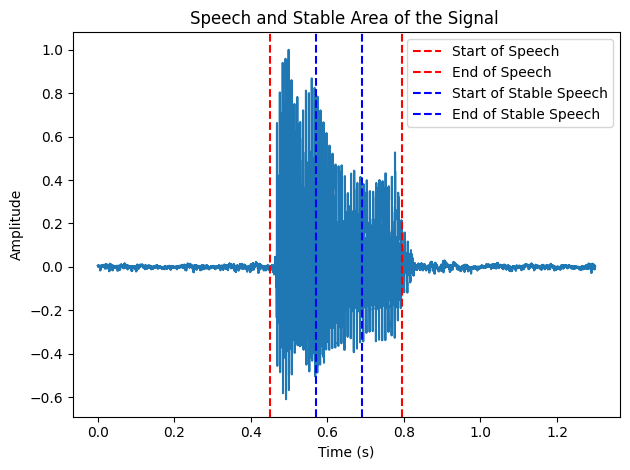

/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Consuming time for a in NguyenAmKiemThu-16k/22MHL/a.wav: 0.020340919494628906

Consuming time for e in NguyenAmKiemThu-16k/16FTH/a.wav: 0.02798008918762207

Consuming time for a in NguyenAmKiemThu-16k/03MAB/a.wav: 0.028801918029785156

Consuming time for a in NguyenAmKiemThu-16k/08MLD/a.wav: 0.024955034255981445

Consuming time for a in NguyenAmKiemThu-16k/11MVD/a.wav: 0.024067163467407227

Consuming time for a in NguyenAmKiemThu-16k/09MPD/a.wav: 0.02553391456604004

Consuming time for a in NguyenAmKiemThu-16k/05MVB/a.wav: 0.025109052658081055

Consuming time for a in NguyenAmKiemThu-16k/20MVK/a.wav: 0.018476009368896484

Consuming time for a in NguyenAmKiemThu-16k/12FTD/a.wav: 0.020902156829833984

Consuming time for a in NguyenAmKiemThu-16k/06FTB/a.wav: 0.025586843490600586

Consuming time for a in NguyenAmKiemThu-16k/14FHH/a.wav: 0.02787303924560547

Consuming time for a in NguyenAmKiemThu-16k/21MTL/a.wav: 0.016614198684692383

Consuming time for a in NguyenAmKiemThu-16k/07FTC/a.wav

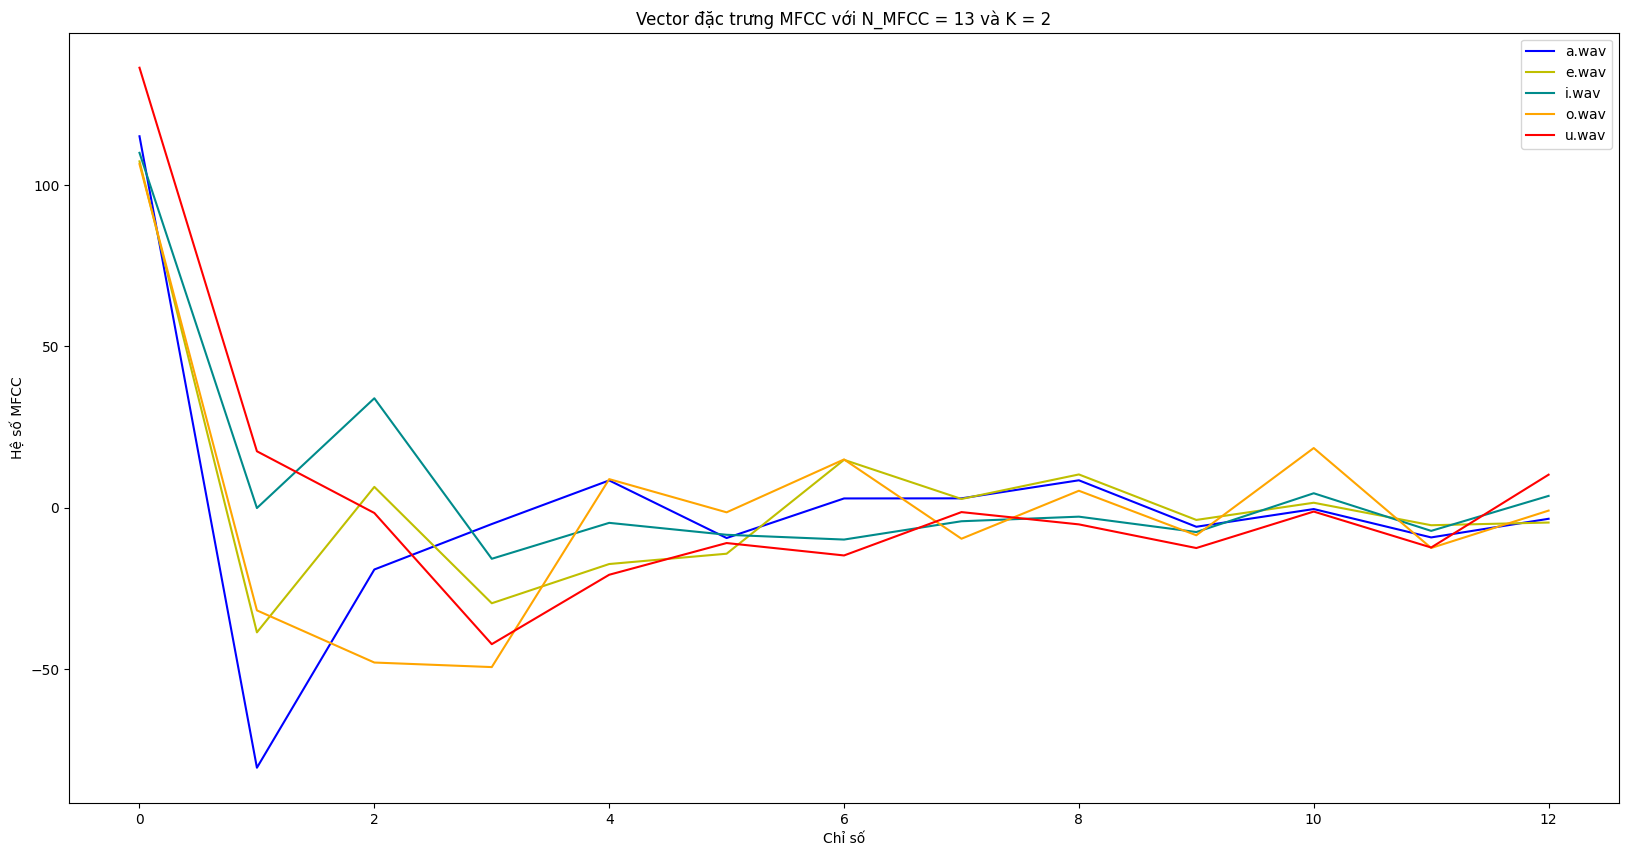

<Figure size 640x480 with 0 Axes>

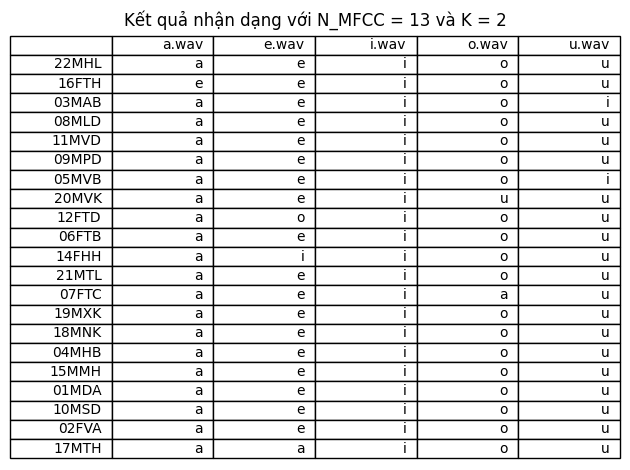

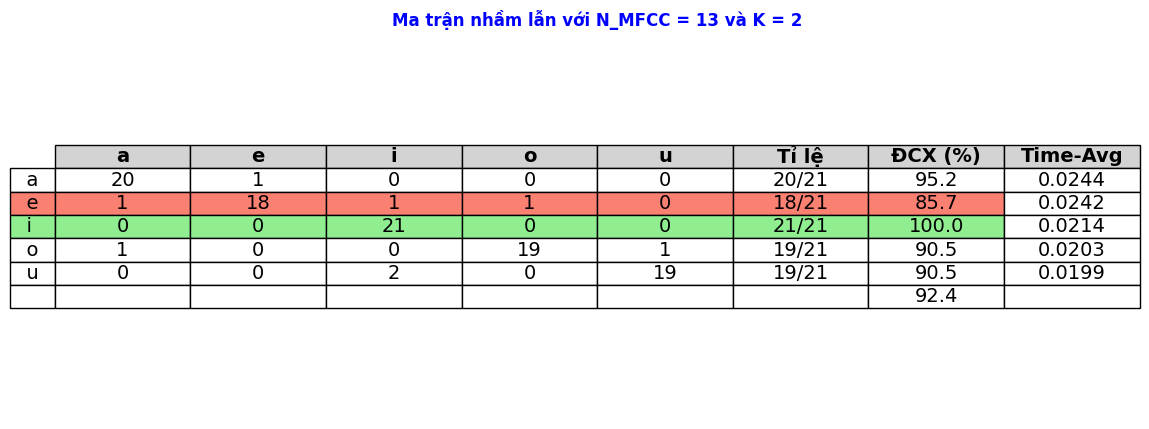

/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Consuming time for a in NguyenAmKiemThu-16k/22MHL/a.wav: 0.020123004913330078

Consuming time for e in NguyenAmKiemThu-16k/16FTH/a.wav: 0.027719974517822266

Consuming time for a in NguyenAmKiemThu-16k/03MAB/a.wav: 0.030111074447631836

Consuming time for a in NguyenAmKiemThu-16k/08MLD/a.wav: 0.023937225341796875

Consuming time for a in NguyenAmKiemThu-16k/11MVD/a.wav: 0.02733302116394043

Consuming time for a in NguyenAmKiemThu-16k/09MPD/a.wav: 0.02890491485595703

Consuming time for a in NguyenAmKiemThu-16k/05MVB/a.wav: 0.03143000602722168

Consuming time for a in NguyenAmKiemThu-16k/20MVK/a.wav: 0.01629781723022461

Consuming time for a in NguyenAmKiemThu-16k/12FTD/a.wav: 0.021916866302490234

Consuming time for a in NguyenAmKiemThu-16k/06FTB/a.wav: 0.027392864227294922

Consuming time for a in NguyenAmKiemThu-16k/14FHH/a.wav: 0.028842926025390625

Consuming time for a in NguyenAmKiemThu-16k/21MTL/a.wav: 0.017112016677856445

Consuming time for a in NguyenAmKiemThu-16k/07FTC/a.wav:

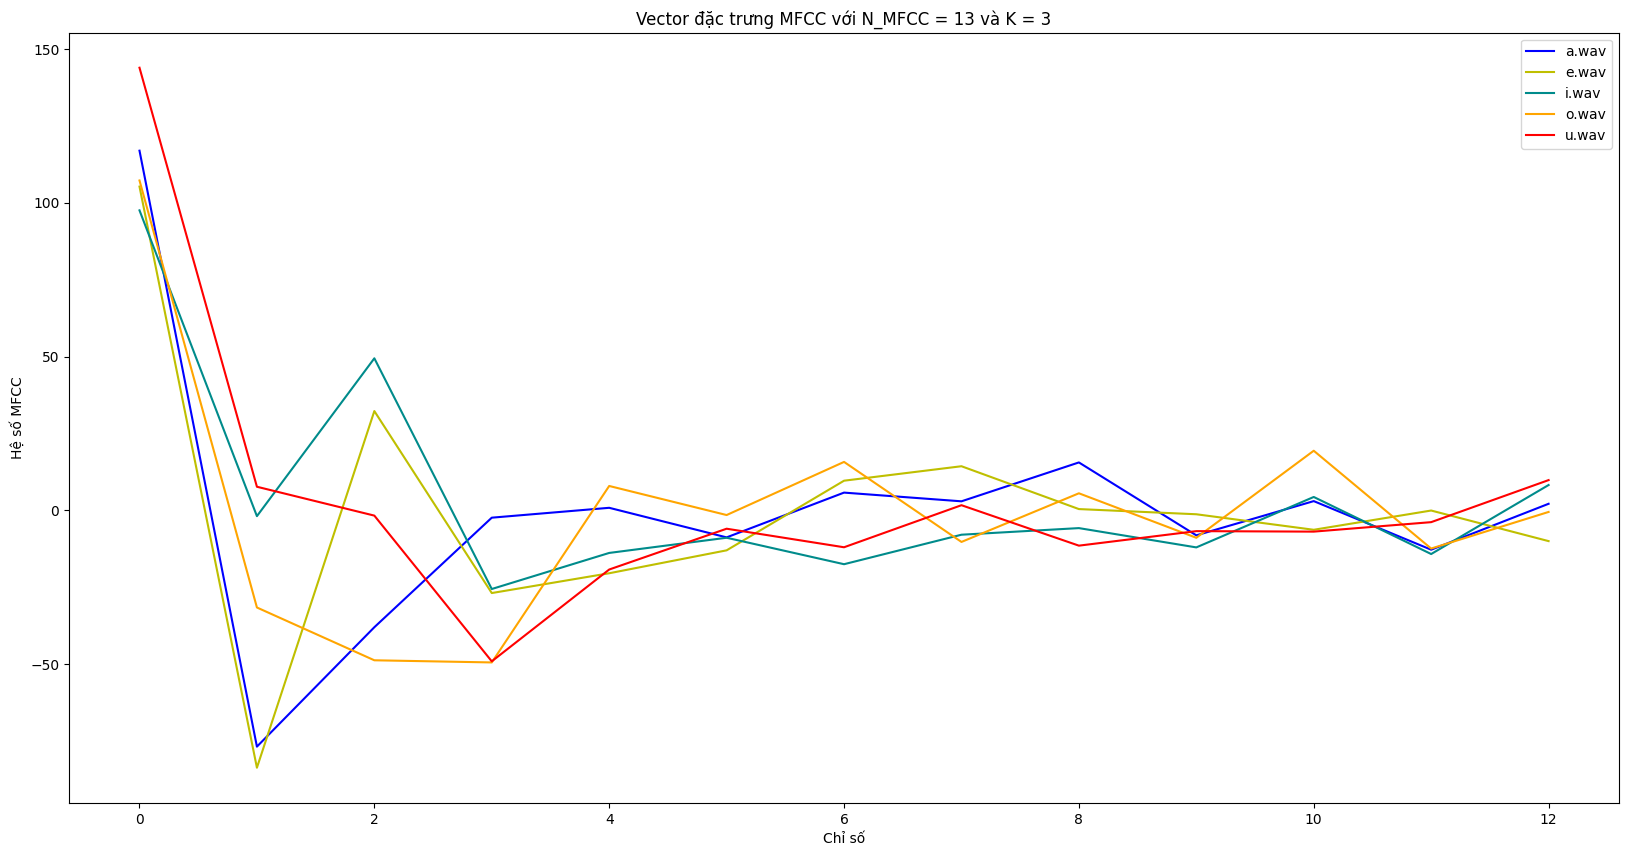

<Figure size 640x480 with 0 Axes>

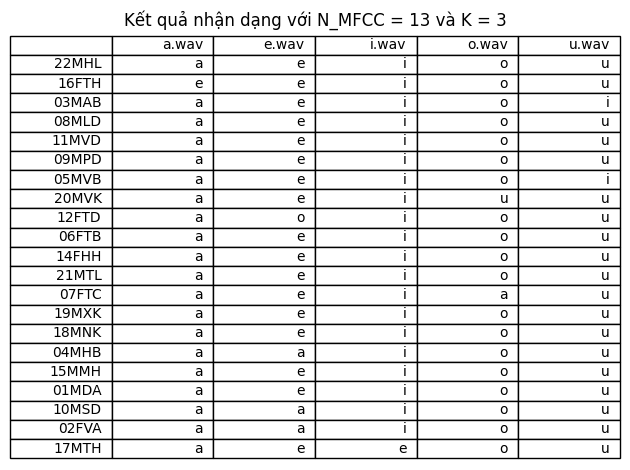

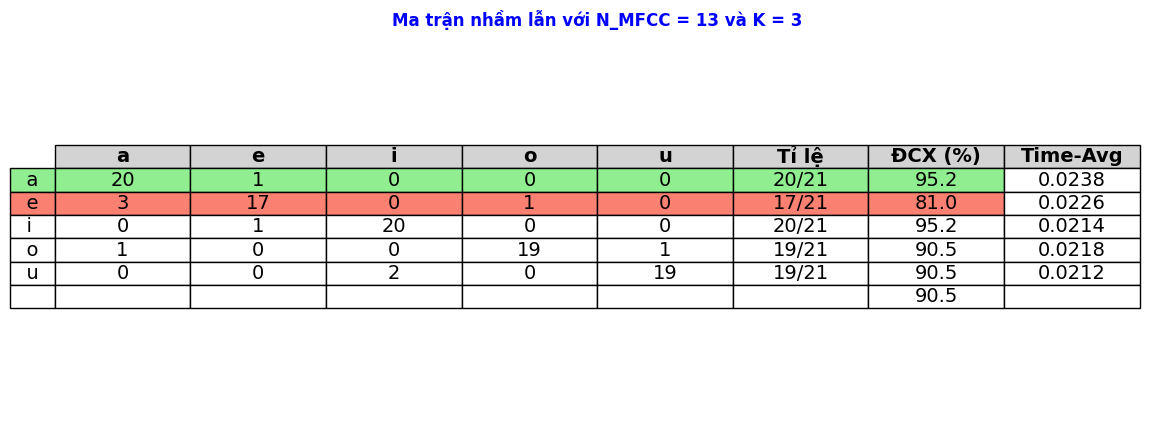

/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Consuming time for a in NguyenAmKiemThu-16k/22MHL/a.wav: 0.021183013916015625

Consuming time for e in NguyenAmKiemThu-16k/16FTH/a.wav: 0.029376745223999023

Consuming time for a in NguyenAmKiemThu-16k/03MAB/a.wav: 0.036988258361816406

Consuming time for a in NguyenAmKiemThu-16k/08MLD/a.wav: 0.0280148983001709

Consuming time for a in NguyenAmKiemThu-16k/11MVD/a.wav: 0.027873754501342773

Consuming time for a in NguyenAmKiemThu-16k/09MPD/a.wav: 0.025197982788085938

Consuming time for a in NguyenAmKiemThu-16k/05MVB/a.wav: 0.02796483039855957

Consuming time for a in NguyenAmKiemThu-16k/20MVK/a.wav: 0.014715194702148438

Consuming time for e in NguyenAmKiemThu-16k/12FTD/a.wav: 0.021249055862426758

Consuming time for a in NguyenAmKiemThu-16k/06FTB/a.wav: 0.024697065353393555

Consuming time for a in NguyenAmKiemThu-16k/14FHH/a.wav: 0.029369115829467773

Consuming time for a in NguyenAmKiemThu-16k/21MTL/a.wav: 0.01772284507751465

Consuming time for a in NguyenAmKiemThu-16k/07FTC/a.wav:

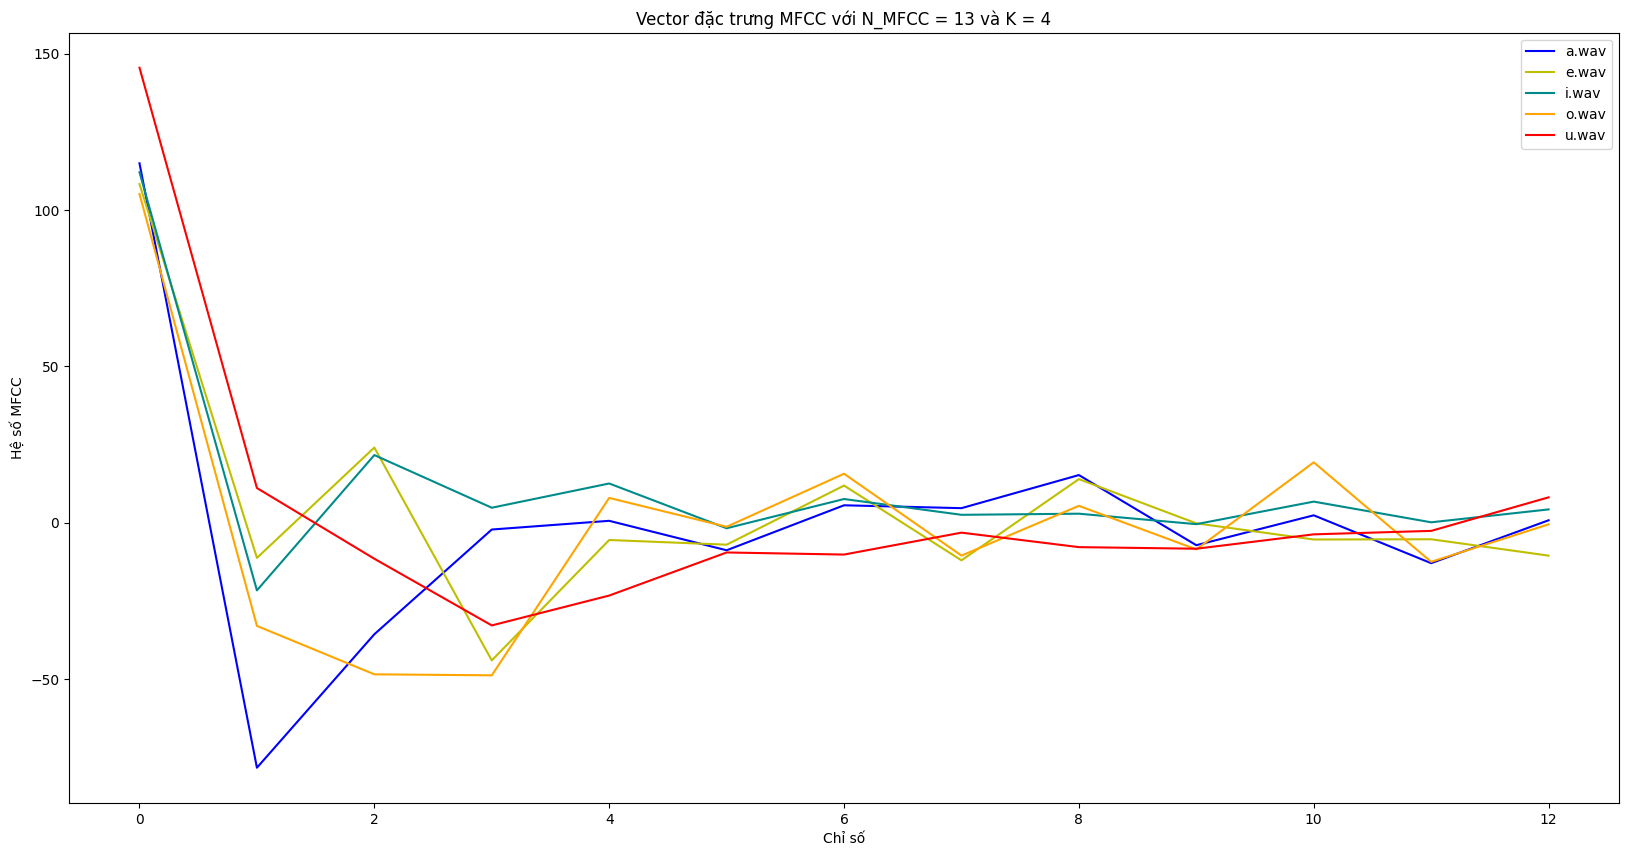

<Figure size 640x480 with 0 Axes>

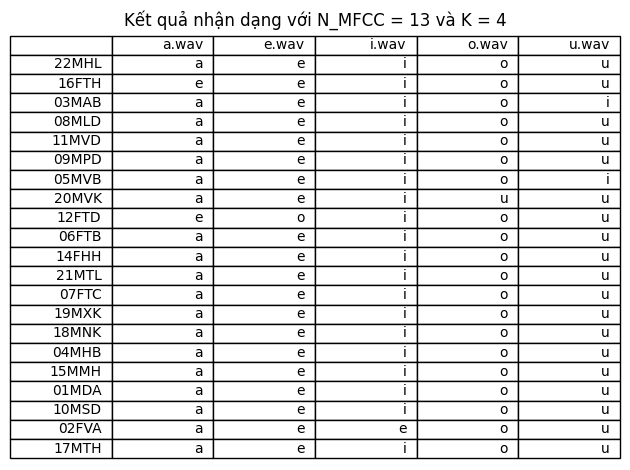

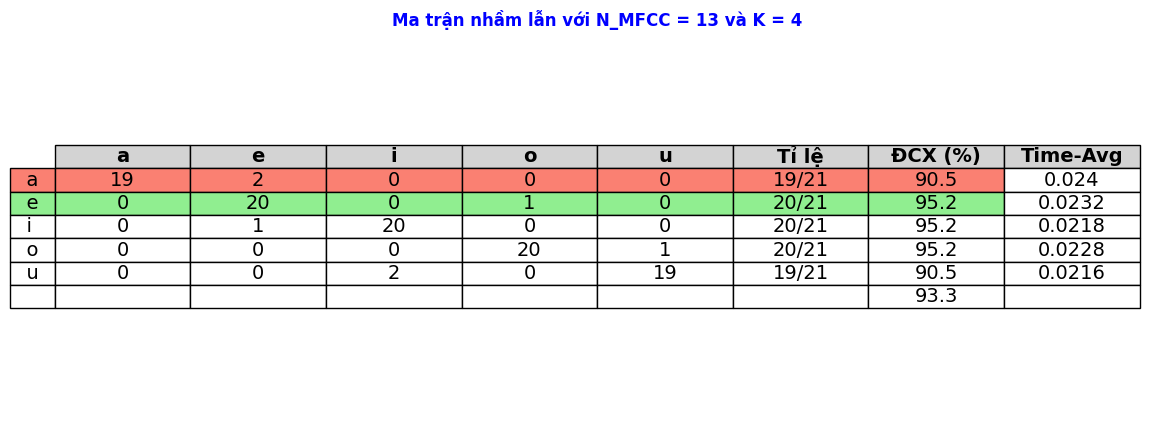

/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_21046/2284769709.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, data = wavfile.read(files) # Lấy tần số lấy mẫu, data của file
/Users/lequangnhat/My Study/4-Signal-Processing/venv_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Consuming time for a in NguyenAmKiemThu-16k/22MHL/a.wav: 0.018726825714111328

Consuming time for e in NguyenAmKiemThu-16k/16FTH/a.wav: 0.030203819274902344

Consuming time for a in NguyenAmKiemThu-16k/03MAB/a.wav: 0.02816319465637207

Consuming time for a in NguyenAmKiemThu-16k/08MLD/a.wav: 0.025660991668701172

Consuming time for a in NguyenAmKiemThu-16k/11MVD/a.wav: 0.026489734649658203

Consuming time for a in NguyenAmKiemThu-16k/09MPD/a.wav: 0.029989004135131836

Consuming time for a in NguyenAmKiemThu-16k/05MVB/a.wav: 0.029186010360717773

Consuming time for a in NguyenAmKiemThu-16k/20MVK/a.wav: 0.016641855239868164

Consuming time for a in NguyenAmKiemThu-16k/12FTD/a.wav: 0.02175617218017578

Consuming time for a in NguyenAmKiemThu-16k/06FTB/a.wav: 0.02516913414001465

Consuming time for a in NguyenAmKiemThu-16k/14FHH/a.wav: 0.028910160064697266

Consuming time for a in NguyenAmKiemThu-16k/21MTL/a.wav: 0.016685962677001953

Consuming time for a in NguyenAmKiemThu-16k/07FTC/a.wav

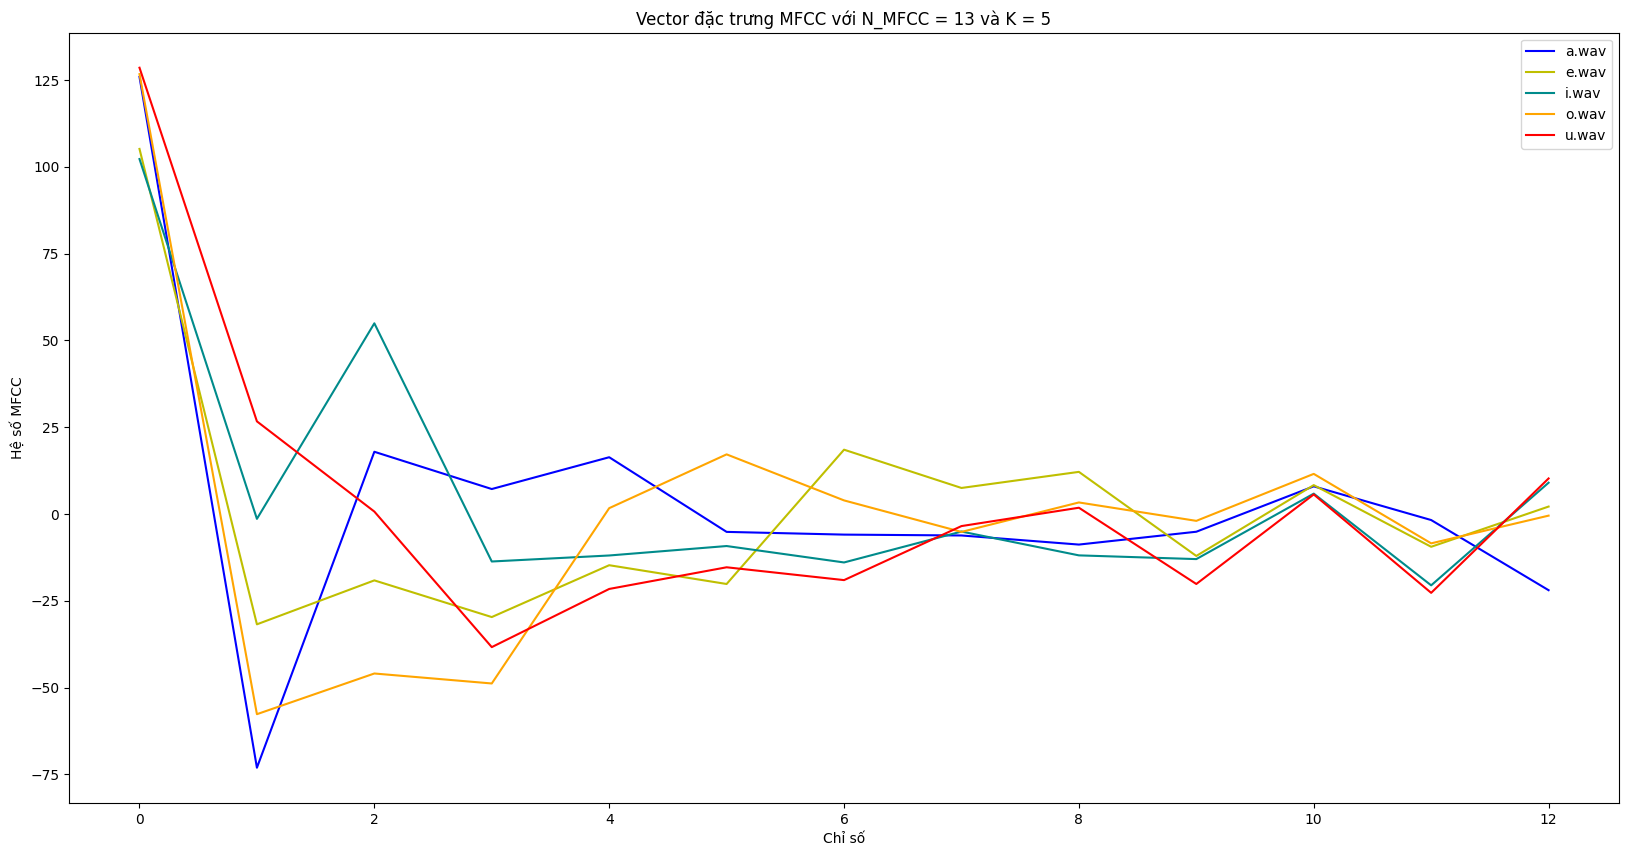

<Figure size 640x480 with 0 Axes>

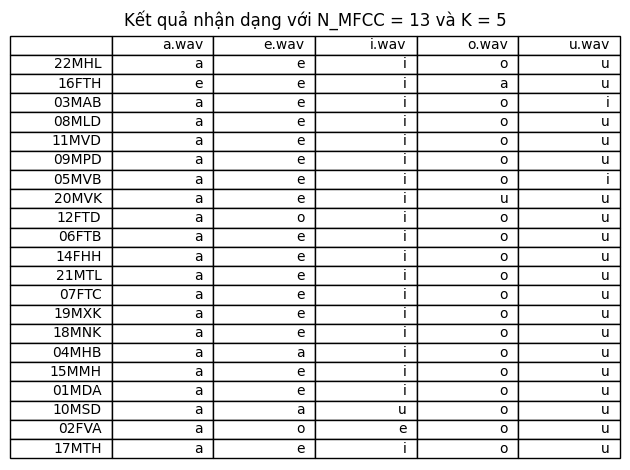

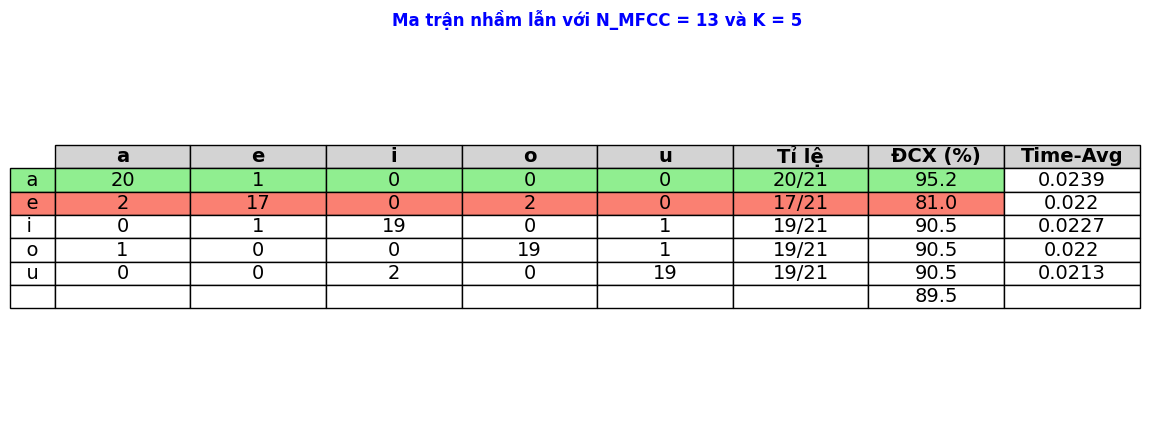

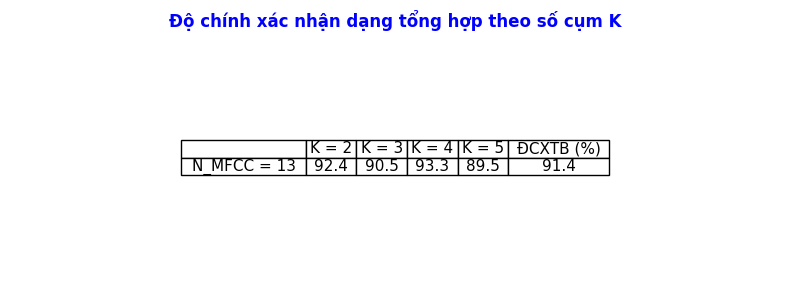

In [270]:
if __name__ == "__main__":
    Bai3()